<a href="https://colab.research.google.com/github/bsatara1/OTS-2025_26-Utjecaj_Nelinearnog_Preslusavanja_XPM_u_WDM_Sistemima/blob/main/XPM_u_WDM_u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

Cloning into 'OptiCommPy'...
remote: Enumerating objects: 13208, done.
remote: Counting objects: 100% (2421/2421), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 13208 (delta 2206), reused 2231 (delta 2090), pack-reused 10787 (from 2)
Receiving objects: 100% (13208/13208), 252.30 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (9851/9851), done.
Updating files: 100% (612/612), done.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.5/749.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 132.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.1 MB/s eta 0:00:00
  Created wheel for OptiCommPy: filename=OptiCommPy-0.11.0-py3-none-any.whl size=109280 sha256=be8c9a0baa811f017ba35d417be8c58f340bf3337a964e27972a1b74f6dc040b
  Stored in directory: /tmp/pip-ephem-wh

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm
from optic.models.devices import pdmCoherentReceiver, basicLaserModel

try:
    from optic.models.modelsGPU import manakovSSF
except:
    from optic.models.channels import manakovSSF

from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.plot import pconst, plotPSD

import scipy.constants as const

import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)
import time

/usr/local/lib/python3.12/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [ ]:
#Funkcija za Eye diagram
from scipy.signal import butter, filtfilt

def plot_eye(signal, SpS, span=30, nTraces=100, title="Eye diagram"):

    samples_per_eye = 2 * SpS  # eye width = 2 simbola
    startInd = SpS * span      # ignorisanje početnog transienta

    plt.figure(figsize=(6,4))
    for i in range(nTraces):
        idx_start = startInd + i * SpS
        idx_end = idx_start + samples_per_eye
        if idx_end <= len(signal):
            segment = signal[idx_start:idx_end]
            plt.plot(segment.real, color='blue', alpha=0.2)
            # plt.plot(segment.imag, color='red', alpha=0.2)  # opcionalno I/Q

    plt.title(title)
    plt.xlim(0,samples_per_eye)
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


def extract_channel(sigWDM, paramTx, paramCh, chIndex=None):
    """
    Ekstraktuje pojedinačni kanal iz WDM signala.

    Parameters:
    -----------
    sigWDM : ndarray
        WDM signal, shape (N_samples, N_polarizations)
    paramTx : object
        Parametri predajnika (mora sadržati: wdmFreqGrid, nChannels, Rs, SpS)
    paramCh : object
        Parametri kanala (mora sadržati: Fc, Fs)
    chIndex : int, optional
        Indeks kanala za ekstrakciju. Ako je None, uzima se centralni kanal.

    Returns:
    --------
    sigCh : ndarray
        Ekstraktovani signal kanala, ista dimenzija kao sigWDM
    """

    # Ako indeks nije specificiran, uzmi centralni kanal
    if chIndex is None:
        chIndex = int(np.floor(paramTx.nChannels / 2))

    # Frekvencijski grid
    freqGrid = paramTx.wdmFreqGrid
    channel_freq = freqGrid[chIndex]

    # Parametri
    Fs = paramCh.Fs
    N = len(sigWDM)
    nPol = sigWDM.shape[1]

    # Frekvencijski shift za dovođenje kanala na baseband
    t = np.arange(N) / Fs
    shift = np.exp(-1j * 2 * np.pi * channel_freq * t)

    # Primeni shift na sve polarizacije
    sigShifted = np.zeros_like(sigWDM, dtype=complex)
    for pol in range(nPol):
        sigShifted[:, pol] = sigWDM[:, pol] * shift

    # Dizajn lowpass filtera za ekstrakciju kanala
    # Bandwidth = symbol rate + malo margine
    bandwidth = paramTx.Rs * 1.2  # 20% margina
    cutoff_freq = bandwidth / 2
    normalized_cutoff = cutoff_freq / (Fs / 2)

    # Butter filter, 5. red
    b, a = butter(5, normalized_cutoff, btype='low')

    # Filtriranje za svaku polarizaciju
    sigCh = np.zeros_like(sigWDM, dtype=complex)
    for pol in range(nPol):
        # Filtriraj I i Q komponente odvojeno
        sigCh[:, pol].real = filtfilt(b, a, sigShifted[:, pol].real)
        sigCh[:, pol].imag = filtfilt(b, a, sigShifted[:, pol].imag)

    return sigCh, chIndex


In [ ]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 4  # order of the modulation format
paramTx.Rs  = 32e9 # symbol rate [baud]
paramTx.SpS = 16  # samples per symbol
paramTx.pulseType = 'rrc' # pulse shaping filter
paramTx.nFilterTaps = 1024 # number of pulse shaping filter coefficients
paramTx.pulseRollOff = 0.01 # RRC rolloff
paramTx.powerPerChannel = -2 # power per WDM channel [dBm]
paramTx.nChannels = 40 # number of WDM channels
paramTx.Fc = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.laserLinewidth = 100e3 # laser linewidth in Hz
paramTx.wdmGridSpacing = 37.5e9 # WDM grid spacing
paramTx.nPolModes = 2  # number of signal modes [2 for polarization multiplexed signals]
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization
paramTx.seed = 123 # random seed for bit generation

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/40 [00:00<?, ?it/s]

channel 0	 fc : 192.3688 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 0	 power: -2.00 dBm

channel 1	 fc : 192.4062 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 1	 power: -2.00 dBm

channel 2	 fc : 192.4437 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 2	 power: -2.00 dBm

channel 3	 fc : 192.4812 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 3	 power: -2.00 dBm

channel 4	 fc : 192.5188 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 4	 power: -2.00 dBm

channel 5	 fc : 192.5563 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 5	 power: -2.00 dBm

channel 6	 fc : 192.5938 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 6	 power: -2.00 dBm

channel 7	 fc : 192.6312 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 7	 power: -2.00 dBm

channel 8	 fc : 192.6687 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
cha

In [ ]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 700     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = True   # show progress bar
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate
paramCh.seed = 456 # random seed for noise generation

# nonlinear signal propagation
sigWDM = manakovSSF(sigWDM_Tx, paramCh)

Running Manakov SSF model on GPU...


  0%|          | 0/14 [00:00<?, ?it/s]

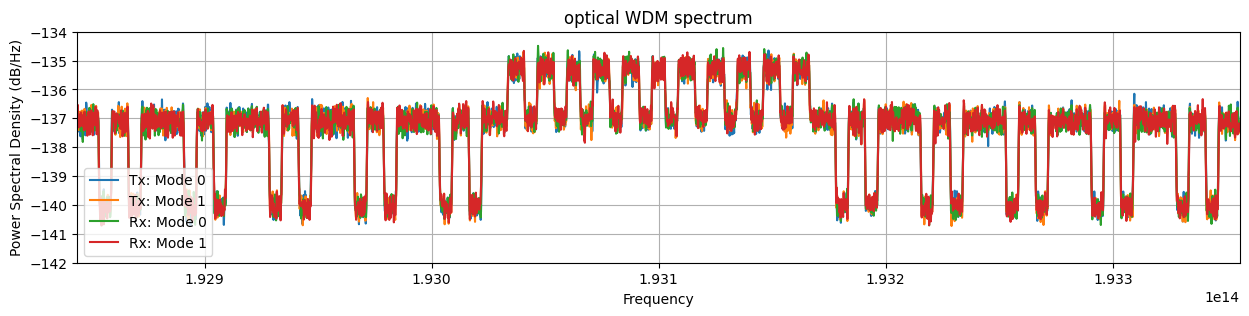

In [ ]:
# plot psd
Fs = paramCh.Fs
fig,_ = plotPSD(sigWDM_Tx, Fs, paramTx.Fc, label='Tx');
fig, ax = plotPSD(sigWDM, Fs, paramTx.Fc, fig=fig, label='Rx');
fig.set_figheight(3)
fig.set_figwidth(15)
ax.set_title('optical WDM spectrum');

Demodulating channel #20 , fc: 193.1188 THz, λ: 1552.3736 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: -128.00 MHz



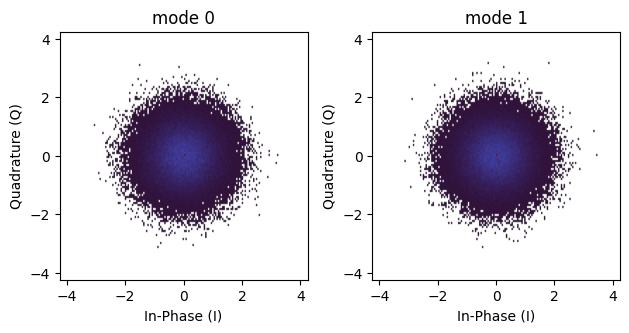

In [ ]:
# Receiver

# parameters
chIndex  = int(np.floor(paramTx.nChannels/2))      # index of the channel to be demodulated
freqGrid = paramTx.wdmFreqGrid
symbTx = symbTx_[:,:,chIndex]

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (paramCh.Fc + freqGrid[chIndex])/1e12, const.c/(paramCh.Fc + freqGrid[chIndex])/1e-9))


# local oscillator (LO) parameters:
FO  = -128e6                 # frequency offset
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigWDM)
paramLO.Fs = Fs
paramLO.seed = 789 # random seed for noise generation
paramLO.freqShift = freqGrid[chIndex] + FO  # downshift of the channel to be demodulated add frequency offset

# generate CW laser LO field
sigLO = basicLaserModel(paramLO)

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# polarization multiplexed coherent optical receiver

# Frontend parameters
paramFE = parameters()
paramFE.Fs = Fs
paramFE.polRotation = np.pi/3    # input polarization rotation angle
paramFE.pdl = 0                  # Polarization dependent loss
paramFE.polDelay = 4e-12         # Polarization delay
paramFE.phaseImbX = 0*np.pi/180  # IQ phase imbalance polarization X in radians
paramFE.phaseImbY = 0*np.pi/180  # IQ phase imbalance polarization Y in radians
paramFE.ampImbX = 0              # IQ amplitude imbalance polarization X in dB
paramFE.ampImbY = 0              # IQ amplitude imbalance polarization Y in dB

# photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.ideal = True
paramPD.seed = 1011

sigRx = pdmCoherentReceiver(sigWDM, sigLO, paramFE, paramPD)

# plot received constellations
pconst(sigRx[0::paramTx.SpS,:], R=3);

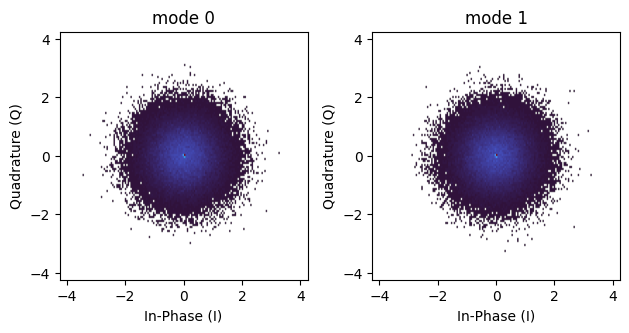

Running CD compensation...
CD filter length: 392 taps, FFT size: 512


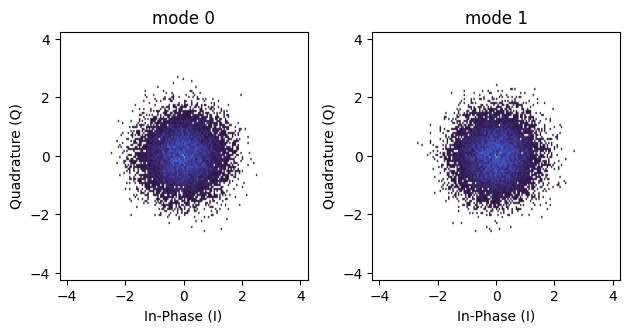

Running adaptive equalizer...
cma - training stage #0
cma pre-convergence training iteration #0
cma MSE = 0.510776.
cma pre-convergence training iteration #1
cma MSE = 0.512534.
cma - training stage #1
cma MSE = 0.509613.


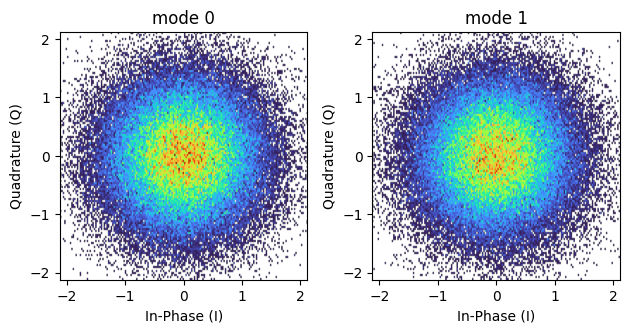

Running frequency offset compensation...
Estimated frequency offset (MHz): [3178.56 3070.48]
Running BPS carrier phase recovery...
Estimated linewidth: 133615.439 kHz


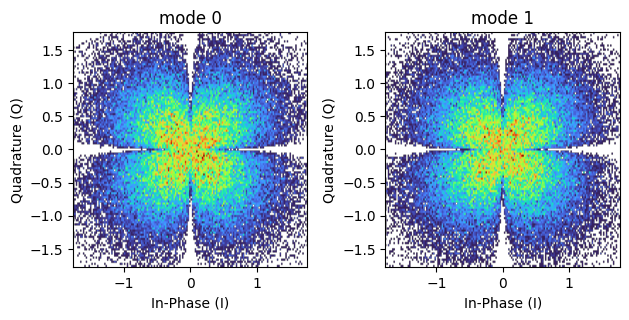

In [ ]:
# ---------------------------
# Matched filtering
# ---------------------------
paramPS = parameters()
paramPS.SpS = paramTx.SpS
paramPS.nFilterTaps = paramTx.nFilterTaps
paramPS.rollOff = paramTx.pulseRollOff
paramPS.pulseType = paramTx.pulseType
pulse = pulseShape(paramPS)

sigRx = firFilter(pulse, sigRx)
pconst(sigRx[0::paramTx.SpS,:], R=3)


# ---------------------------
# Decimation
# ---------------------------
paramDec = parameters()
paramDec.SpSin  = paramTx.SpS
paramDec.SpSout = 2
sigRx = decimate(sigRx, paramDec)


# ---------------------------
# CD compensation
# ---------------------------
paramEDC = parameters()
paramEDC.L = paramCh.Ltotal
paramEDC.D = paramCh.D
paramEDC.Fc = paramCh.Fc
paramEDC.Rs = paramTx.Rs
paramEDC.Fs = 2*paramTx.Rs

sigRx = edc(sigRx, paramEDC)
pconst(sigRx[0::paramTx.SpS,:], R=3)


# ---------------------------
# Symbol synchronization and normalization
# ---------------------------
symbRx = symbolSync(sigRx, symbTx, 2)
x = pnorm(sigRx)
d = pnorm(symbTx)


# ---------------------------
# Adaptive equalization
# ---------------------------
paramEq = parameters()
paramEq.nTaps = 35
paramEq.SpS = paramDec.SpSout
paramEq.numIter = 2
paramEq.storeCoeff = False
paramEq.M = paramTx.M
paramEq.shapingFactor = paramTx.shapingFactor
paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
paramEq.prgsBar = False

if paramTx.M == 4:
    paramEq.alg = ['cma','cma'] # QPSK
    paramEq.mu = [5e-3, 1e-3]
else:
    paramEq.alg = ['da-rde','rde'] # M-QAM
    paramEq.mu = [5e-3, 5e-4]

y_EQ = mimoAdaptEqualizer(x, paramEq, d)
discard = 5000
pconst(y_EQ[discard:-discard,:], R=1.5)


# ---------------------------
# Carrier phase recovery
# ---------------------------
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.constType = paramTx.constType
paramCPR.shapingFactor = paramTx.shapingFactor
paramCPR.N   = 25
paramCPR.B   = 64
paramCPR.returnPhases = False
paramCPR.Ts = 1/paramTx.Rs

y_CPR = cpr(y_EQ, paramCPR)
pconst(y_CPR[discard:-discard,:])


# ---------------------------
# Metrics evaluation
# ---------------------------
ind = np.arange(discard, d.shape[0]-discard)

if paramTx.M == 4:
    d = symbTx
    rot0 = [np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,0])), np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,0]))]
    rot1 = [np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,1])), np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,1]))]

    if np.argmax(np.abs(rot0)) == 1 and np.argmax(np.abs(rot1)) == 1:
        y_CPR_ = y_CPR.copy()
        y_CPR[:,0] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR_[:,1])
        y_CPR[:,1] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR_[:,0])
    else:
        y_CPR[:,0] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR[:,0])
        y_CPR[:,1] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR[:,1])


BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam',px=paramTx.pmf)
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam',px=paramTx.pmf)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam',px=paramTx.pmf)
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])


      pol.X      pol.Y      
 SER: 7.48e-01,  7.49e-01
 BER: 4.98e-01,  4.98e-01
 SNR: -3.00 dB,  -3.00 dB
 EVM: 100.01 %,    100.06 %
  MI: -0.33 bits, -0.33 bits
 GMI: -0.33 bits, -0.33 bits
NGMI: -0.16,      -0.16


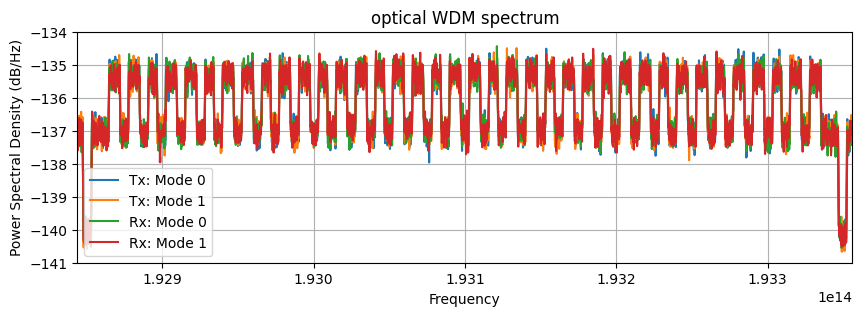

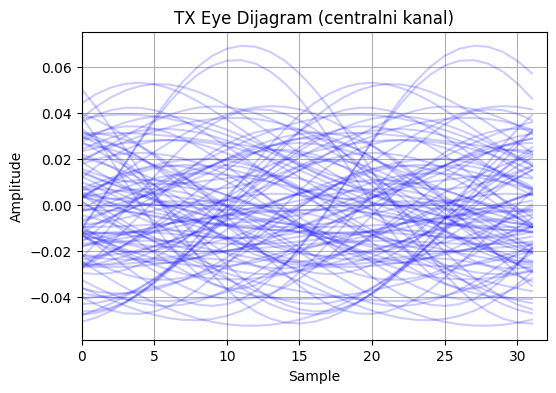

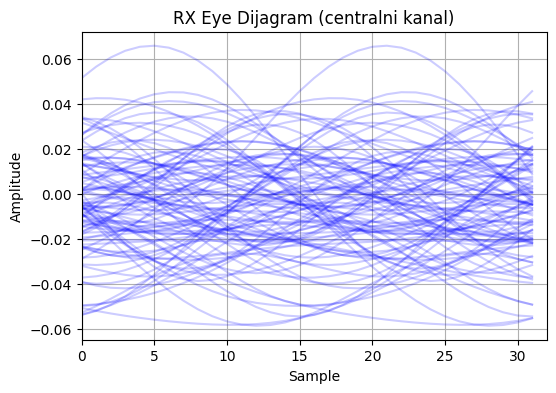

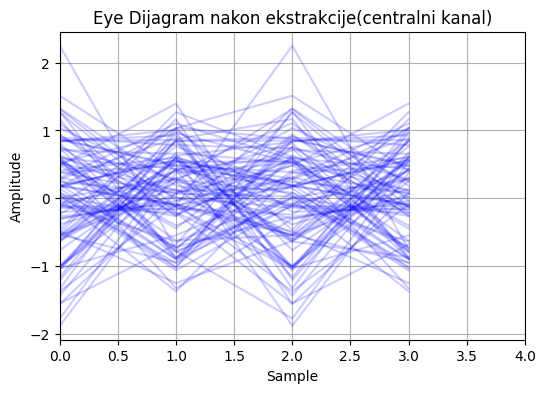

In [ ]:
print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))


# plot psd
Fs = paramCh.Fs
fig,_ = plotPSD(sigWDM_Tx, Fs, paramTx.Fc, label='Tx');
fig, ax = plotPSD(sigWDM, Fs, paramTx.Fc, fig=fig, label='Rx');
fig.set_figheight(3)
fig.set_figwidth(10)
ax.set_title('optical WDM spectrum');

# Ekstraktuj centralni kanal
sigTx_ch, chIdx = extract_channel(sigWDM_Tx, paramTx, paramCh)
sigRx_ch, _ = extract_channel(sigWDM, paramTx, paramCh, chIndex=chIdx)

# Eye diagram primljenog i predajnog signala (centralni kanal, prva pol)
eye_tx = sigTx_ch[:, 0]
eye_rx = sigRx_ch[:, 0]
eye_end = y_CPR[:, 0]
plot_eye(eye_tx, paramTx.SpS, title="TX Eye Dijagram (centralni kanal)")
plot_eye(eye_rx, paramTx.SpS, title="RX Eye Dijagram (centralni kanal)")
plot_eye(eye_end, 2, title="Eye Dijagram nakon ekstrakcije(centralni kanal)")